In [1]:
import string
import torch
import torchvision
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
SEED = 42
DATA_PATH = 'dataset'


In [4]:
LABELS = string.digits + string.ascii_lowercase
LABEL_TO_ID = {c:i for i, c in enumerate(LABELS)}
ID_TO_LABEL = {i: c for i, c in enumerate(LABELS)}

In [5]:
class ImageDataset(Dataset):
    def __init__(self, path, transforms=None, channels=None, left_side=None, right_side=None):
        self.path = path
        self.filenames = os.listdir(path)
        self.transforms = transforms
        self.left_side = left_side
        self.right_side = right_side
        self.channels = channels
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.path, filename)
        image = Image.open(image_path)
        if self.transforms:
            image = self.transforms(image)
            
            if self.channels == 'mean':
                image = image.mean(axis=0, keepdims=True)
            elif self.channels == 3:
                image = image[0:3, :]

                
        if self.left_side and self.right_side:
            image = image[:, :, self.left_side : self.right_side + 1]
            
        label = filename[:-4]
        label_list = torch.tensor([LABEL_TO_ID[l] for l in label])
        return image, label_list

In [6]:
transforms = torchvision.transforms.ToTensor()
dataset = ImageDataset(DATA_PATH, transforms)

In [7]:
to_pil = torchvision.transforms.ToPILImage()

label: 3ebnn
torch.Size([4, 50, 200])


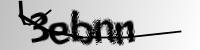

In [8]:
sample_idx = -89
sample = dataset[sample_idx]
print('label:', ''.join([ID_TO_LABEL[k.item()] for k in sample[1]]))
print(sample[0].shape)
to_pil(sample[0])

Last channel is empty:

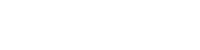

In [9]:
to_pil(sample[0][-1])

Show first channel and mean of the channels

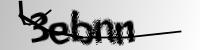

In [10]:
to_pil(sample[0][0])

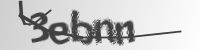

In [11]:
to_pil(sample[0].mean(axis=0))

## Define borders

There is large left and right padding, lets compute padding length:

In [12]:
test_size = len(dataset) // 5
train_size = len(dataset) - test_size

In [13]:
torch.manual_seed(SEED + 5)
dataset = ImageDataset(DATA_PATH, transforms=transforms, channels=3)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print('train size:', train_size)
print('test_size:', test_size)

train size: 856
test_size: 214


In [14]:
BS = 32
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

In [15]:
from matplotlib import pyplot as plt

In [16]:
def build_mean_image(loader):
    data = []
    for img, _ in iter(loader):
        data.append(img.mean(axis=(0,1)).numpy())
    data = np.array(data).mean(axis=0)
    return data

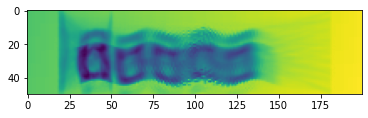

In [17]:
plt.imshow(build_mean_image(train_loader))

In [18]:
LEFT_SIDE = 20
RIGHT_SIDE = 150
DELTA = 2

Lets check this assumption on test data:

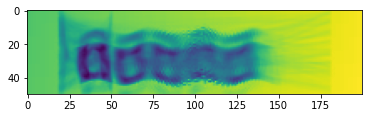

In [19]:
plt.imshow(build_mean_image(test_loader))

In [20]:
dataset = ImageDataset(DATA_PATH, transforms, channels=3, left_side=(LEFT_SIDE - DELTA), right_side=(RIGHT_SIDE + DELTA))
# dataset = ImageDataset(DATA_PATH, transforms, channels=3)
sample = dataset[0]
torch.manual_seed(SEED)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=0)

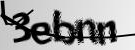

In [21]:
to_pil(dataset[sample_idx][0])

## Model (create and training)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
(torch.tensor([[1,2,3], [1,2,3]]) == torch.tensor([[1,2,3], [1,2,3]])).sum().item()

6

In [24]:
def train_step(model, dataloader, criterion, optimizer, num_epochs=10, device=device):
    model.train()
    for i in range(num_epochs):
        epoch_loss = []
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            out = model(X)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        print(f'Epoch: {i}, loss: {round(np.mean(epoch_loss), 4)}')

In [25]:
def test_step(model, dataloader, criterion, device=device):
    model.eval()
    with torch.no_grad():
        true_ans = []
        model_ans = []
        epoch_loss = []
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            epoch_loss.append(loss.item())
            
            true_ans.extend(y.cpu().numpy())
            _, ans = torch.max(out, dim=1)
            
            model_ans.extend(ans.cpu().numpy())
        
    test_loss = np.mean(epoch_loss)
    model_ans = np.array(model_ans)
    true_ans = np.array(true_ans)
    
    return test_loss, model_ans, true_ans

In [26]:
def cer(preds, labels):
    return 1 - (preds == labels).mean()

In [27]:
class Model(nn.Module):
    def __init__(self, in_channels):
        super(Model, self).__init__(),
        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.mp1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(64, 128, 3)
        self.mp2 = nn.MaxPool2d(2)
        
    
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.mp3 = nn.MaxPool2d((1, 2), stride=2)
        
        self.conv5 = nn.Conv2d(256, 512, 3)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.mp4 = nn.MaxPool2d((1, 2), stride=2)
        
        self.conv7 = nn.Conv2d(512, 512, 2)


        self.rnn = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, len(LABELS))

    def forward(self, x):
        bs = x.shape[0]
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.mp3(x)
        
        x = F.relu(self.bn1((self.conv5(x))))
        x = F.relu(self.bn2((self.conv6(x))))       
        x = self.mp4(x)
        
        x = F.relu(self.conv7(x))

        x = x.reshape(bs, -1, 5).permute(0, 2, 1)
        
        x = F.relu(self.rnn(x)[0])
        x = self.fc(x)
        
        return x.permute(0, 2, 1)

In [28]:
net = Model(in_channels=3).to(device)

In [29]:
num_params = sum([p.numel() for p in net.parameters() if p.requires_grad])
print('Number of parameters:', num_params)

Number of parameters: 8724388


In [30]:
sample = dataset[0]
pred = net(sample[0].unsqueeze(0).to(device))

In [31]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

In [32]:
train_step(net, train_loader, criterion, opt, num_epochs=40)

Epoch: 0, loss: 3.5384
Epoch: 1, loss: 3.4303
Epoch: 2, loss: 3.2928
Epoch: 3, loss: 3.147
Epoch: 4, loss: 3.0209
Epoch: 5, loss: 2.9135
Epoch: 6, loss: 2.8168
Epoch: 7, loss: 2.7187
Epoch: 8, loss: 2.6109
Epoch: 9, loss: 2.498
Epoch: 10, loss: 2.3738
Epoch: 11, loss: 2.2465
Epoch: 12, loss: 2.1117
Epoch: 13, loss: 1.9739
Epoch: 14, loss: 1.8428
Epoch: 15, loss: 1.7032
Epoch: 16, loss: 1.5667
Epoch: 17, loss: 1.4343
Epoch: 18, loss: 1.3091
Epoch: 19, loss: 1.1862
Epoch: 20, loss: 1.0713
Epoch: 21, loss: 0.9627
Epoch: 22, loss: 0.8636
Epoch: 23, loss: 0.7714
Epoch: 24, loss: 0.6868
Epoch: 25, loss: 0.6121
Epoch: 26, loss: 0.5464
Epoch: 27, loss: 0.4888
Epoch: 28, loss: 0.439
Epoch: 29, loss: 0.3946
Epoch: 30, loss: 0.3566
Epoch: 31, loss: 0.3225
Epoch: 32, loss: 0.2932
Epoch: 33, loss: 0.2678
Epoch: 34, loss: 0.2457
Epoch: 35, loss: 0.2258
Epoch: 36, loss: 0.2084
Epoch: 37, loss: 0.1928
Epoch: 38, loss: 0.1791
Epoch: 39, loss: 0.1669


In [33]:
test_loss, preds, labels = test_step(net, test_loader, criterion)

In [34]:
print(test_loss, cer(preds, labels))

0.2961101084947586 0.03738317757009346


## Errors

In [35]:
bads = []

for sample_idx, (tr, err) in enumerate(zip(labels, preds)):
    if np.any(tr != err):
        label = ''.join([ID_TO_LABEL[i] for i in tr])
        pred = ''.join([ID_TO_LABEL[i] for i in err])
        print(f'id: {sample_idx}, label/prediction: {label}/{pred}')
        bads.append(sample_idx)
print('Wrong labels recognized:',len(bads))

id: 0, label/prediction: m74dm/m744d
id: 8, label/prediction: pnmxf/pnmxx
id: 26, label/prediction: cwmny/cwmmm
id: 31, label/prediction: pwmbn/pwmmn
id: 33, label/prediction: w52fn/w522n
id: 52, label/prediction: bp6mw/bp6mm
id: 54, label/prediction: wce5n/wccem
id: 60, label/prediction: mmfm6/mmnfm
id: 75, label/prediction: nf2n8/mf2n8
id: 79, label/prediction: gw468/gw446
id: 84, label/prediction: ep85x/cp85x
id: 91, label/prediction: 76nxn/76mxn
id: 94, label/prediction: pm47f/pm447
id: 135, label/prediction: 3w2bw/3w22w
id: 139, label/prediction: ewcf5/ewcff
id: 140, label/prediction: m2nf4/m22n4
id: 141, label/prediction: m75bf/m75bb
id: 150, label/prediction: w2yp7/w22y7
id: 151, label/prediction: mc8w2/mcc8w
id: 154, label/prediction: bw44w/bw444
id: 155, label/prediction: bw6n6/bw666
id: 157, label/prediction: dmw8n/dmw8m
id: 182, label/prediction: 4m2w5/4m22w
id: 184, label/prediction: b5nmm/b5mmm
id: 188, label/prediction: mmg2m/mmg2n
id: 194, label/prediction: bwmee/bwmne
i

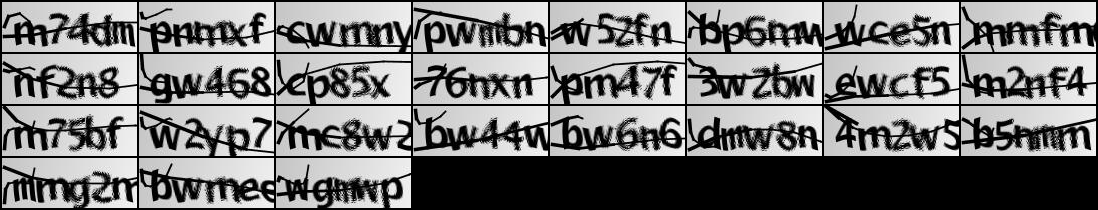

In [36]:
bads_tensors = [test_dataset[i][0] for i in range(len(test_dataset)) if i in bads]
to_pil(torchvision.utils.make_grid(bads_tensors))